In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.fft import fft, ifft

In [2]:
# standards
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['lines.linewidth'] = 1

In [3]:
u0 = 10 # in m/s
C_0 = 10

L = 2500e3 # in m
dx = 25e3 # in m
T = L / u0 # in s
dt = 10 # in s


x_arr = np.arange(0, L, dx)
t_arr = np.arange(0, T + dt, dt)
C0 = np.zeros(len(x_arr))
C0[x_arr >= 1125e3] = C_0
C0[x_arr > 1375e3] = 0

In [4]:
def forward_upwind(C10, C11, dt, dx, u0):
    '''
    C-time-space
    start both at index 1
    '''
    C21 = C11 - dt * u0 / dx * (C11-C10)
    return C21

def lax_wendrof(C10, C11, C12, dt, dx, u0):
    C21 = C11 + dt * (-u0 * (C12 - C10) / (2*dx) + u0**2 * dt * (C12 - 2*C11 + C10) / (2*dx**2))
    return C21   

def matsuno(C1, dt, dx, u0):
    k = np.array(np.fft.fftfreq(len(C1)) * len(C1), dtype=int)
    L = len(C1) * dx
    C2_pred = C1 * ( 1 - dt * 2j * np.pi * u0 * k / L)
    C2 = C1 - C2_pred * dt * 2j * np.pi * u0 * k / L
    return C2

def spectral(C, dt, dx, u0):
    f_coef = np.zeros_like(C, dtype=np.complex_)
    f_coef[0] = fft(C[0])
    
    for tidx, f_coef_t in enumerate(f_coef):
        if tidx == len(f_coef)-1:
            break
        f_coef[tidx+1] = matsuno(f_coef_t, dt, dx, u0)
    return f_coef


In [5]:
def do_integration(C0, dt, dx, u0, scheme="euler"):
    C = np.zeros((len(t_arr), len(x_arr)))
    C[0] = C0
    if scheme=="spectral":
        f_coef = spectral(C, dt, dx, u0)
        return f_coef

    for tidx, ct in enumerate(C):
        if tidx == len(C)-1:
            break
        for xidx, cx in enumerate(ct):
            C10 = C[tidx, xidx-1]
            C11 = cx
            
            if scheme == "euler":
                C[tidx+1, xidx] = forward_upwind(C10, C11, dt, dx, u0)
                
            if scheme == "lax-wendrof":
                C12 = C[tidx, xidx+1] if xidx < len(ct)-1 else C[tidx, 0]
                C[tidx+1, xidx] = lax_wendrof(C10, C11, C12, dt, dx, u0)
    return C

In [6]:
%%time
C_eul = do_integration(C0, dt, dx, u0, scheme="euler")

CPU times: total: 2.88 s
Wall time: 2.89 s


In [7]:
%%time
C_lax = do_integration(C0, dt, dx, u0, scheme="lax-wendrof")

CPU times: total: 8.17 s
Wall time: 8.37 s


In [8]:
%%time
F_spec = do_integration(C0, dt, dx, u0, scheme="spectral")

CPU times: total: 625 ms
Wall time: 659 ms


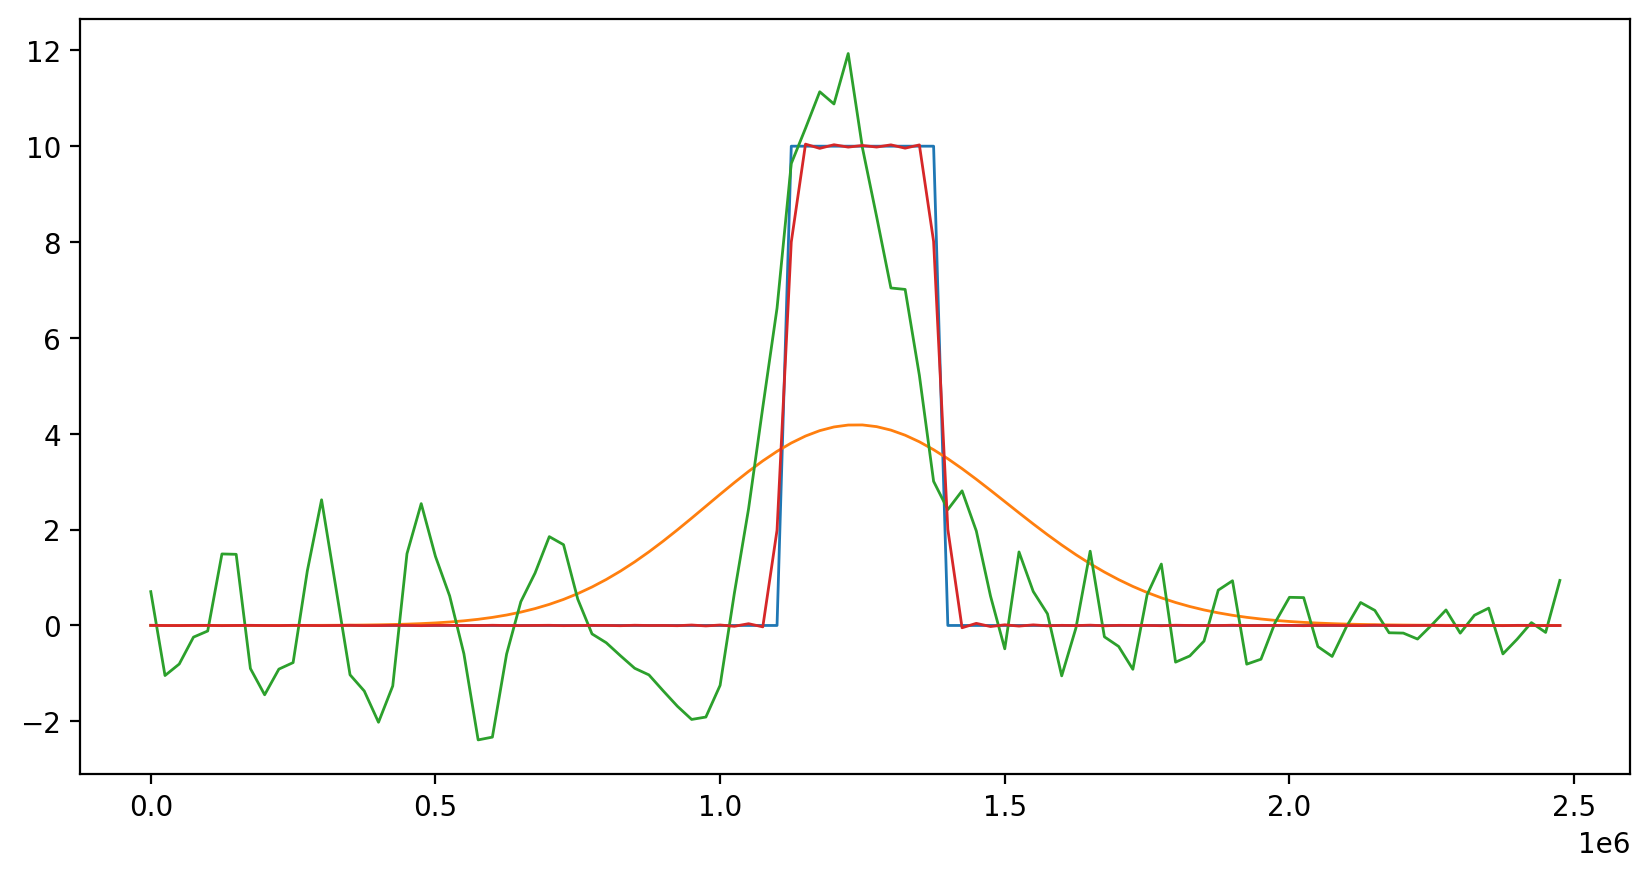

In [9]:
plt.plot(x_arr, C0)
plt.plot(x_arr, C_eul[-1], label="Euler")
plt.plot(x_arr, C_lax[-1], label="Lax-Wendrof")
plt.plot(x_arr, np.real(ifft(F_spec[-1])), label="Spectral")